In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, concatenate, Embedding, LSTM, Dense, Activation
from keras.callbacks import EarlyStopping

from keras.utils import np_utils, plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

import numpy as np
import pandas as pd

from datetime import datetime,timedelta
import matplotlib.pyplot as plt

Using TensorFlow backend.


# load data

In [78]:
def get_ugrd_data(year, lon, lat):
    csv_dir_path="../data/csv"
    file_path="{0}/{1}/{2}".format(csv_dir_path, lon, lat)

    ugrd_file_name="{0}/{1}_{2}_UGRD_{3}.csv".format(file_path, lon, lat, year)
    ugrd_data = np.genfromtxt(ugrd_file_name, delimiter=",", dtype='float')
    return ugrd_data[:,1]

def get_vgrd_data(year, lon, lat):
    csv_dir_path="../data/csv"
    file_path="{0}/{1}/{2}".format(csv_dir_path, lon, lat)

    vgrd_file_name="{0}/{1}_{2}_VGRD_{3}.csv".format(file_path, lon, lat, year)
    vgrd_data = np.genfromtxt(vgrd_file_name, delimiter=",", dtype='float')
    return vgrd_data[:,1]

lons=["139.2500", "139.3125", "139.3750", "139.4375"]
lats=["35.20", "35.25", "35.30", "35.35", "35.40"]
# lons=["139.3125"]
# lats=["35.30"]

data_msm = pd.DataFrame()

for year in range(2013, 2018):
    data_msm_year = pd.DataFrame()
    data_msm_year["time"] = pd.date_range('{0}-07-01 9:00:00'.format(year), periods=1488, freq='H')
    i = 0
    for lon in lons:
        for lat in lats:
            data_msm_year["UGRD_{0}".format(i)] = get_ugrd_data(year, lon, lat)
            data_msm_year["VGRD_{0}".format(i)] = get_vgrd_data(year, lon, lat)
            i = i + 1
    data_msm = pd.concat([data_msm, data_msm_year])
data_msm = data_msm.reset_index(drop=True)

In [79]:
avg_10min_data_path = "../data/hiratsuka/avg_10min"
prediction_delta =  60 # 何分間後を予測するか

data_hiratsuka = pd.DataFrame()
for year in range(2013, 2018):
    data_path = "{0}/{1}".format(avg_10min_data_path, year)
    data_hiratsuka_year = pd.DataFrame(columns=["UGRD", "VGRD"])
    for month in range(7, 8 + 1):
        for day in range(1, 31 + 1):
            file_name = "{0}{1:02d}{2:02d}.csv".format(year, month, day)
            file_dath = "{0}/{1}".format(data_path, file_name)

            data_day = pd.read_csv(file_dath, header=0)
            data_hiratsuka_year = pd.concat([data_hiratsuka_year, data_day[["UGRD", "VGRD"]]])
            
    data_hiratsuka_year["time"] = pd.date_range('{0}-07-01 00:00:00'.format(year), periods=8928 ,freq='10min')
    # 平塚データに1時間後の正解データを追加
    data_hiratsuka_1h_later = data_hiratsuka_year.shift(int(-prediction_delta/10))
    data_hiratsuka_1h_later.columns = ["UGRD_later", "VGRD_later", "time_later"]
    data_hiratsuka_year = pd.concat([data_hiratsuka_year, data_hiratsuka_1h_later], axis=1)
    
    data_hiratsuka = pd.concat([data_hiratsuka, data_hiratsuka_year])
data_hiratsuka = data_hiratsuka.reset_index(drop = True)

In [80]:
# データ欠損
data_msm.shape, data_msm.dropna().shape, data_hiratsuka.shape, data_hiratsuka.dropna().shape

((7440, 41), (7440, 41), (44640, 6), (44000, 6))

In [81]:
# 平塚欠損データ（元データが欠損しているもの）
data_hiratsuka[data_hiratsuka[["UGRD", "VGRD", "time"]].isnull().any(1)]

,UGRD,VGRD,time,UGRD_later,VGRD_later,time_later
3105,NaN,NaN,2013-07-22 13:30:00,-2.033881,7.300367,2013-07-22 14:30:00
3106,NaN,NaN,2013-07-22 13:40:00,-2.294176,6.825628,2013-07-22 14:40:00
8928,NaN,NaN,2014-07-01 00:00:00,NaN,NaN,2014-07-01 01:00:00
8929,NaN,NaN,2014-07-01 00:10:00,NaN,NaN,2014-07-01 01:10:00
8930,NaN,NaN,2014-07-01 00:20:00,NaN,NaN,2014-07-01 01:20:00
8931,NaN,NaN,2014-07-01 00:30:00,NaN,NaN,2014-07-01 01:30:00
8932,NaN,NaN,2014-07-01 00:40:00,NaN,NaN,2014-07-01 01:40:00
8933,NaN,NaN,2014-07-01 00:50:00,NaN,NaN,2014-07-01 01:50:00
8934,NaN,NaN,2014-07-01 01:00:00,NaN,NaN,2014-07-01 02:00:00
8935,NaN,NaN,2014-07-01 01:10:00,NaN,NaN,2014-07-01 02:10:00


# format data


In [82]:
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)
data_msm_amp

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,UGRD_15,VGRD_15,UGRD_16,VGRD_16,UGRD_17,VGRD_17,UGRD_18,VGRD_18,UGRD_19,VGRD_19
0,2013-07-01 09:00:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
1,2013-07-01 09:10:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
2,2013-07-01 09:20:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
3,2013-07-01 09:30:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
4,2013-07-01 09:40:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
5,2013-07-01 09:50:00,-2.38087,3.11136,-2.09180,3.05667,-1.357430,2.40823,-0.904305,2.12698,-0.623055,...,-3.22462,3.03323,-2.84962,3.13480,-1.75587,2.50198,-0.904305,2.00980,-0.576180,1.96292
6,2013-07-01 10:00:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829
7,2013-07-01 10:10:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829
8,2013-07-01 10:20:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829
9,2013-07-01 10:30:00,-2.27571,3.21360,-1.90852,3.26829,-1.166340,2.66673,-0.689773,2.41673,-0.400710,...,-2.28352,3.14329,-2.01009,3.36985,-1.28352,2.96360,-0.666335,2.57298,-0.369460,2.51829


In [83]:
data = pd.merge(data_msm_amp, data_hiratsuka, how='outer')
# (62*24*6+9*6)*5=44910 rows
data = data.dropna()
data

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,VGRD_17,UGRD_18,VGRD_18,UGRD_19,VGRD_19,UGRD,VGRD,UGRD_later,VGRD_later,time_later
0,2013-07-01 09:00:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.373967,0.643112,0.521693,1.736634,2013-07-01 10:00:00
1,2013-07-01 09:10:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.424892,0.971913,0.576053,1.856262,2013-07-01 10:10:00
2,2013-07-01 09:20:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.296973,1.553636,0.820446,1.913099,2013-07-01 10:20:00
3,2013-07-01 09:30:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,1.002564,1.733061,1.310781,1.704048,2013-07-01 10:30:00
4,2013-07-01 09:40:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,0.770078,1.812200,2.186517,1.461793,2013-07-01 10:40:00
5,2013-07-01 09:50:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,2.50198,-0.904305,2.00980,-0.576180,1.96292,0.533275,1.838867,2.686342,1.520277,2013-07-01 10:50:00
6,2013-07-01 10:00:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,0.521693,1.736634,2.754610,1.712231,2013-07-01 11:00:00
7,2013-07-01 10:10:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,0.576053,1.856262,3.078829,1.625499,2013-07-01 11:10:00
8,2013-07-01 10:20:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,0.820446,1.913099,2.663094,1.652499,2013-07-01 11:20:00
9,2013-07-01 10:30:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,2.96360,-0.666335,2.57298,-0.369460,2.51829,1.310781,1.704048,2.228942,1.554432,2013-07-01 11:30:00


# training

In [84]:
# training, test data
# 2013~2016を訓練データ、2017年をテストデータとする
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

test_data

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,VGRD_17,UGRD_18,VGRD_18,UGRD_19,VGRD_19,UGRD,VGRD,UGRD_later,VGRD_later,time_later
35712,2017-07-01 09:00:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.461566,-4.880211,-1.338525,-3.033009,2017-07-01 10:00:00
35713,2017-07-01 09:10:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.734624,-5.027068,-1.346466,-2.380519,2017-07-01 10:10:00
35714,2017-07-01 09:20:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.706208,-5.096804,-0.957121,0.136084,2017-07-01 10:20:00
35715,2017-07-01 09:30:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.277506,-4.503880,-2.220179,-0.488646,2017-07-01 10:30:00
35716,2017-07-01 09:40:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-2.104033,-3.746856,-2.088313,-1.862035,2017-07-01 10:40:00
35717,2017-07-01 09:50:00,-1.34344,-2.086220,-2.08562,-2.492470,-1.60125,-1.742470,-1.163750,-1.148720,-0.585625,...,-2.992470,-0.273125,-2.187790,-0.265312,-1.836220,-1.627120,-2.515108,-1.659325,-0.877446,2017-07-01 10:50:00
35718,2017-07-01 10:00:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-1.338525,-3.033009,-1.671322,-0.980282,2017-07-01 11:00:00
35719,2017-07-01 10:10:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-1.346466,-2.380519,-0.424894,0.006221,2017-07-01 11:10:00
35720,2017-07-01 10:20:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-0.957121,0.136084,0.171446,-0.148841,2017-07-01 11:20:00
35721,2017-07-01 10:30:00,-3.23715,-2.517100,-2.91684,-1.985850,-1.79184,-1.103030,-1.338710,-0.735847,-0.862149,...,-1.462410,-0.744962,-1.118660,-0.534024,-1.040530,-2.220179,-0.488646,-0.009193,-0.002421,2017-07-01 11:30:00


In [85]:
input_columns = []
input_columns.append("UGRD")
input_columns.append("VGRD")
for i in range(0,20):
    input_columns.append("UGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}".format(i))

label_columns = ["UGRD_later", "VGRD_later"]

train_x = train_data[input_columns]
train_y = train_data[label_columns]
test_x = test_data[input_columns]
test_y = test_data[label_columns]

In [86]:
i = 0
print("i,\tlon,\tlat,\tUGRD,\tVGRD")
for lon in lons:
    for lat in lats:
        print("{0},\t{1},\t{2},\t{3:04f},\t{4:04f}".format(i, lon, lat, mean_squared_error(test_data["UGRD_{0}".format(i)], test_data["UGRD"]), mean_squared_error(test_data["VGRD_{0}".format(i)], test_data["VGRD"])))
        i = i+1

i,	lon,	lat,	UGRD,	VGRD
0,	139.2500,	35.20,	4.095835,	4.708124
1,	139.2500,	35.25,	3.588854,	4.770420
2,	139.2500,	35.30,	4.096590,	8.495628
3,	139.2500,	35.35,	4.183734,	13.428321
4,	139.2500,	35.40,	4.014174,	13.916991
5,	139.3125,	35.20,	4.286712,	5.139098
6,	139.3125,	35.25,	3.563479,	4.529015
7,	139.3125,	35.30,	3.445168,	5.982628
8,	139.3125,	35.35,	4.090956,	10.565575
9,	139.3125,	35.40,	4.390886,	11.536093
10,	139.3750,	35.20,	4.557107,	5.575845
11,	139.3750,	35.25,	3.744974,	4.918988
12,	139.3750,	35.30,	3.283322,	5.154320
13,	139.3750,	35.35,	4.163024,	9.028239
14,	139.3750,	35.40,	4.638129,	10.804449
15,	139.4375,	35.20,	4.883292,	5.934844
16,	139.4375,	35.25,	4.067781,	5.268827
17,	139.4375,	35.30,	3.362174,	5.413088
18,	139.4375,	35.35,	4.197971,	9.212107
19,	139.4375,	35.40,	4.666142,	11.121144


In [95]:
model_v = Sequential()
model_v.add(Dense(100, input_dim = 42))
model_v.add(Activation('relu'))
model_v.add(Dense(100))
model_v.add(Activation('relu'))
model_v.add(Dense(1))
model_v.summary()
model_v.compile(optimizer = 'adam', loss = 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               4300      
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 14,501
Trainable params: 14,501
Non-trainable params: 0
_________________________________________________________________


In [96]:
#Early-stopping
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_v.fit(np.array(train_x), np.array(train_y["VGRD_later"]), batch_size=10240, epochs = 1000, validation_split=0.1, callbacks=[callback])

Train on 31424 samples, validate on 3492 samples
Epoch 1/1000
31424/31424 [==============================] - 0s - loss: 14.5205 - val_loss: 19.4283
Epoch 2/1000
31424/31424 [==============================] - 0s - loss: 6.6989 - val_loss: 5.9808
Epoch 3/1000
31424/31424 [==============================] - 0s - loss: 4.8809 - val_loss: 5.7555
Epoch 4/1000
31424/31424 [==============================] - 0s - loss: 4.3575 - val_loss: 5.3636
Epoch 5/1000
31424/31424 [==============================] - 0s - loss: 3.7373 - val_loss: 5.4601
Epoch 6/1000
31424/31424 [==============================] - 0s - loss: 3.7492 - val_loss: 5.5305
Epoch 7/1000
31424/31424 [==============================] - 0s - loss: 3.5068 - val_loss: 5.5214
Epoch 8/1000
31424/31424 [==============================] - 0s - loss: 3.3472 - val_loss: 5.7375
Epoch 9/1000
31424/31424 [==============================] - 0s - loss: 3.3012 - val_loss: 5.4095
Epoch 10/1000
31424/31424 [==============================] - 0s - loss: 3.18

In [97]:
mean_squared_error(model_v.predict(np.array(test_x)), test_y["VGRD_later"])

2.5103246323216064

In [98]:
# １時間前の値をそのまま使う
mean_squared_error(test_x["VGRD"], test_y["VGRD_later"])

2.7700746785119219

#  visualization

In [99]:
def plot_wind(data_array, column_array, label_array, start=None, end=None):
    
    fig = plt.figure(figsize=(18, 12), dpi=80)
    ax1 = fig.add_subplot(2,1,1)
    
    if start is not None and end is not None:
        data_array_ = []
        for data in data_array:
            data_ = data.query('time >= \"{0}\" & time < \"{1}\"'.format(start, end))
            data_array_.append(data_)
        data_array = data_array_
    
    for (data, column, label) in zip(data_array, column_array, label_array) :
        ax1.plot(data["time"], data[column], label = label)

    plt.legend()
    plt.show()

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


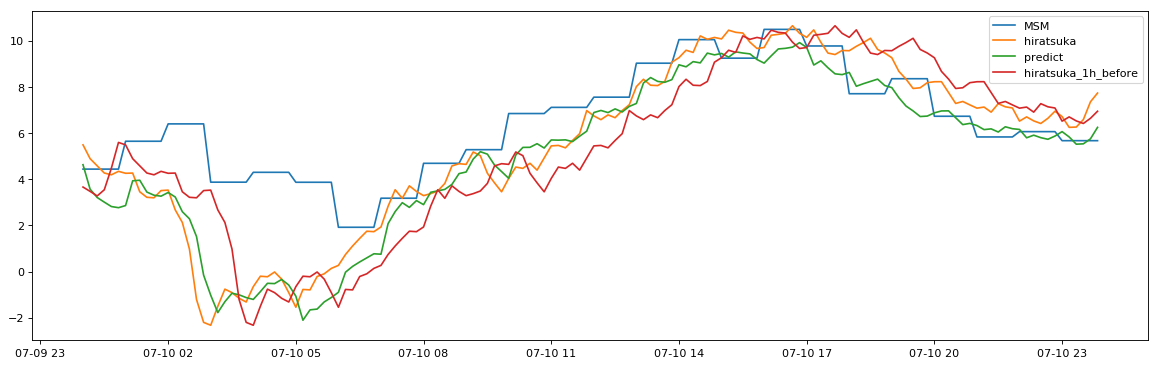

In [100]:
start = datetime(2017,7,10,0,0,0)
end = datetime(2017,7,11,0,0,0)
data_1 = test_data[["time", "VGRD_0"]]
data_2 = test_data[["time", "VGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_v.predict(np.array(test_x))
data_4 = test_data[["time", "VGRD"]]
data_4["time"] = data_4["time"] + timedelta(hours=1)

plot_wind([data_1, data_2, data_3, data_4], ["VGRD_0", "VGRD", "predict", "VGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)

# version2
入力のMSMを１時間後の値にする

In [137]:
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)
data_msm_amp["time"] = data_msm_amp["time"] + timedelta(hours=-1)

data = pd.merge(data_msm_amp, data_hiratsuka, how='outer')
data = data.dropna()

In [139]:
data[["time", "UGRD_0"]]

,time,UGRD_0
0,2013-07-01 08:00:00,-2.38087
1,2013-07-01 08:10:00,-2.38087
2,2013-07-01 08:20:00,-2.38087
3,2013-07-01 08:30:00,-2.38087
4,2013-07-01 08:40:00,-2.38087
5,2013-07-01 08:50:00,-2.38087
6,2013-07-01 09:00:00,-2.27571
7,2013-07-01 09:10:00,-2.27571
8,2013-07-01 09:20:00,-2.27571
9,2013-07-01 09:30:00,-2.27571


In [140]:
# training, test data
# 2013~2016を訓練データ、2017年をテストデータとする
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

input_columns = []
input_columns.append("UGRD")
input_columns.append("VGRD")
for i in range(0,20):
    input_columns.append("UGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}".format(i))

label_columns = ["UGRD_later", "VGRD_later"]

train_x = train_data[input_columns]
train_y = train_data[label_columns]
test_x = test_data[input_columns]
test_y = test_data[label_columns]

i = 0
print("i,\tlon,\tlat,\tUGRD,\tVGRD")
for lon in lons:
    for lat in lats:
        print("{0},\t{1},\t{2},\t{3:04f},\t{4:04f}".format(i, lon, lat, mean_squared_error(test_data["UGRD_{0}".format(i)], test_data["UGRD"]), mean_squared_error(test_data["VGRD_{0}".format(i)], test_data["VGRD"])))
        i = i+1

i,	lon,	lat,	UGRD,	VGRD
0,	139.2500,	35.20,	3.957101,	4.215563
1,	139.2500,	35.25,	3.514800,	4.456848
2,	139.2500,	35.30,	4.057201,	8.427047
3,	139.2500,	35.35,	4.139275,	13.495287
4,	139.2500,	35.40,	3.969071,	14.052513
5,	139.3125,	35.20,	4.043733,	4.400018
6,	139.3125,	35.25,	3.375127,	3.879754
7,	139.3125,	35.30,	3.349215,	5.633869
8,	139.3125,	35.35,	4.057636,	10.464144
9,	139.3125,	35.40,	4.366481,	11.518987
10,	139.3750,	35.20,	4.279729,	4.699524
11,	139.3750,	35.25,	3.492788,	4.097861
12,	139.3750,	35.30,	3.130681,	4.627366
13,	139.3750,	35.35,	4.110725,	8.793836
14,	139.3750,	35.40,	4.618506,	10.677900
15,	139.4375,	35.20,	4.625221,	4.995073
16,	139.4375,	35.25,	3.813486,	4.408255
17,	139.4375,	35.30,	3.212382,	4.856725
18,	139.4375,	35.35,	4.148109,	8.940419
19,	139.4375,	35.40,	4.640828,	10.935415


In [141]:
model_v = Sequential()
model_v.add(Dense(100, input_dim = 42))
model_v.add(Activation('relu'))
model_v.add(Dense(100))
model_v.add(Activation('relu'))
model_v.add(Dense(1))
model_v.summary()
model_v.compile(optimizer = 'adam', loss = 'mse')
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_v.fit(np.array(train_x), np.array(train_y["VGRD_later"]), batch_size=10240, epochs = 1000, validation_split=0.1, callbacks=[callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 100)               4300      
_________________________________________________________________
activation_18 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_19 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 101       
Total params: 14,501
Trainable params: 14,501
Non-trainable params: 0
_________________________________________________________________
Train on 31440 samples, validate on 3494 samples
Epoch 1/1000
31440/31440 [==============================] - 0s - loss: 18.2470 - val_loss

In [142]:
mean_squared_error(model_v.predict(np.array(test_x)), test_y["VGRD_later"])

2.2528510255439613

In [143]:
# １時間前の値をそのまま使う
mean_squared_error(test_x["VGRD"], test_y["VGRD_later"])

2.7691735627136498

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


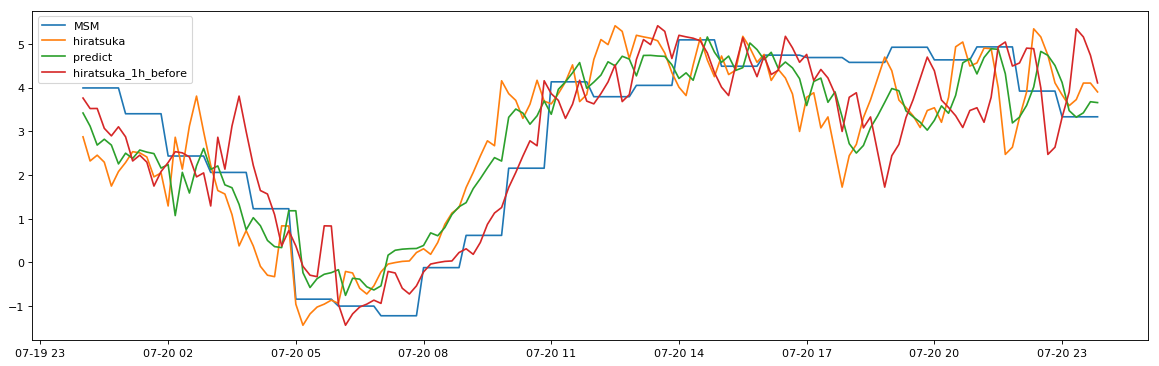

In [144]:
start = datetime(2017,7,20,0,0,0)
end = start + timedelta(days=1)
data_1 = test_data[["time", "VGRD_0"]]
data_2 = test_data[["time", "VGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_v.predict(np.array(test_x))
data_4 = test_data[["time", "VGRD"]]
data_4["time"] = data_4["time"] + timedelta(hours=1)

plot_wind([data_1, data_2, data_3, data_4], ["VGRD_0", "VGRD", "predict", "VGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)

# version3
MSMを今と一時間後にする

In [145]:
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)

data = pd.merge(data_msm_amp, data_hiratsuka, on="time", how='outer')

data_msm_amp["time"] = data_msm_amp["time"] + timedelta(hours=-1)
data = pd.merge(data, data_msm_amp, on="time", how='outer', suffixes=('', '_1h_later'))

data = data.dropna()

In [146]:
data

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,UGRD_15_1h_later,VGRD_15_1h_later,UGRD_16_1h_later,VGRD_16_1h_later,UGRD_17_1h_later,VGRD_17_1h_later,UGRD_18_1h_later,VGRD_18_1h_later,UGRD_19_1h_later,VGRD_19_1h_later
0,2013-07-01 09:00:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
1,2013-07-01 09:10:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
2,2013-07-01 09:20:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
3,2013-07-01 09:30:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
4,2013-07-01 09:40:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
5,2013-07-01 09:50:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
6,2013-07-01 10:00:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114
7,2013-07-01 10:10:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114
8,2013-07-01 10:20:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114
9,2013-07-01 10:30:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114


In [147]:
# training, test data
# 2013~2016を訓練データ、2017年をテストデータとする
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

input_columns = []
input_columns.append("UGRD")
input_columns.append("VGRD")
for i in range(0,20):
    input_columns.append("UGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("UGRD_{0}_1h_later".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}_1h_later".format(i))

label_columns = ["UGRD_later", "VGRD_later"]

train_x = train_data[input_columns]
train_y = train_data[label_columns]
test_x = test_data[input_columns]
test_y = test_data[label_columns]

i = 0
print("i,\tlon,\tlat,\tUGRD,\tVGRD")
for lon in lons:
    for lat in lats:
        print("{0},\t{1},\t{2},\t{3:04f},\t{4:04f}".format(i, lon, lat, mean_squared_error(test_data["UGRD_{0}".format(i)], test_data["UGRD"]), mean_squared_error(test_data["VGRD_{0}".format(i)], test_data["VGRD"])))
        i = i+1

i,	lon,	lat,	UGRD,	VGRD
0,	139.2500,	35.20,	4.095835,	4.708124
1,	139.2500,	35.25,	3.588854,	4.770420
2,	139.2500,	35.30,	4.096590,	8.495628
3,	139.2500,	35.35,	4.183734,	13.428321
4,	139.2500,	35.40,	4.014174,	13.916991
5,	139.3125,	35.20,	4.286712,	5.139098
6,	139.3125,	35.25,	3.563479,	4.529015
7,	139.3125,	35.30,	3.445168,	5.982628
8,	139.3125,	35.35,	4.090956,	10.565575
9,	139.3125,	35.40,	4.390886,	11.536093
10,	139.3750,	35.20,	4.557107,	5.575845
11,	139.3750,	35.25,	3.744974,	4.918988
12,	139.3750,	35.30,	3.283322,	5.154320
13,	139.3750,	35.35,	4.163024,	9.028239
14,	139.3750,	35.40,	4.638129,	10.804449
15,	139.4375,	35.20,	4.883292,	5.934844
16,	139.4375,	35.25,	4.067781,	5.268827
17,	139.4375,	35.30,	3.362174,	5.413088
18,	139.4375,	35.35,	4.197971,	9.212107
19,	139.4375,	35.40,	4.666142,	11.121144


In [148]:
model_v = Sequential()
model_v.add(Dense(100, input_dim = 82))
model_v.add(Activation('relu'))
model_v.add(Dense(100))
model_v.add(Activation('relu'))
model_v.add(Dense(1))
model_v.summary()
model_v.compile(optimizer = 'adam', loss = 'mse')
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_v.fit(np.array(train_x), np.array(train_y["VGRD_later"]), batch_size=10240, epochs = 1000, validation_split=0.1, callbacks=[callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 100)               8300      
_________________________________________________________________
activation_20 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_21 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 101       
Total params: 18,501
Trainable params: 18,501
Non-trainable params: 0
_________________________________________________________________
Train on 31424 samples, validate on 3492 samples
Epoch 1/1000
31424/31424 [==============================] - 0s - loss: 16.7900 - val_loss

In [149]:
mean_squared_error(model_v.predict(np.array(test_x)), test_y["VGRD_later"])

2.2440381689054907

In [150]:
# １時間前の値をそのまま使う
mean_squared_error(test_x["VGRD"], test_y["VGRD_later"])

2.7700746785119219

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


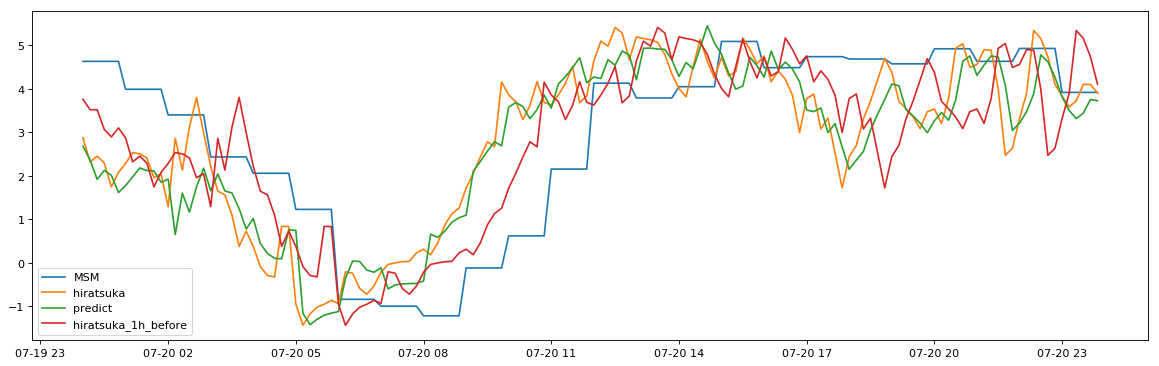

In [151]:
start = datetime(2017,7,20,0,0,0)
end = start + timedelta(days=1)
data_1 = test_data[["time", "VGRD_0"]]
data_2 = test_data[["time", "VGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_v.predict(np.array(test_x))
data_4 = test_data[["time", "VGRD"]]
data_4["time"] = data_4["time"] + timedelta(hours=1)

plot_wind([data_1, data_2, data_3, data_4], ["VGRD_0", "VGRD", "predict", "VGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)

# version 4
MSMのみで

In [152]:
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)
data_msm_amp["time"] = data_msm_amp["time"] + timedelta(hours=1)

data = pd.merge(data_msm_amp, data_hiratsuka, how='outer')
data = data.dropna()

In [153]:
# training, test data
# 2013~2016を訓練データ、2017年をテストデータとする
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

input_columns = []
# input_columns.append("UGRD")
# input_columns.append("VGRD")
for i in range(0,20):
    input_columns.append("UGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}".format(i))

label_columns = ["UGRD_later", "VGRD_later"]

train_x = train_data[input_columns]
train_y = train_data[label_columns]
test_x = test_data[input_columns]
test_y = test_data[label_columns]

i = 0
print("i,\tlon,\tlat,\tUGRD,\tVGRD")
for lon in lons:
    for lat in lats:
        print("{0},\t{1},\t{2},\t{3:04f},\t{4:04f}".format(i, lon, lat, mean_squared_error(test_data["UGRD_{0}".format(i)], test_data["UGRD"]), mean_squared_error(test_data["VGRD_{0}".format(i)], test_data["VGRD"])))
        i = i+1

i,	lon,	lat,	UGRD,	VGRD
0,	139.2500,	35.20,	4.496068,	5.913289
1,	139.2500,	35.25,	3.918703,	5.716834
2,	139.2500,	35.30,	4.272247,	9.025467
3,	139.2500,	35.35,	4.326015,	13.712448
4,	139.2500,	35.40,	4.149847,	14.161897
5,	139.3125,	35.20,	4.735402,	6.606694
6,	139.3125,	35.25,	3.988316,	5.851632
7,	139.3125,	35.30,	3.696424,	6.863358
8,	139.3125,	35.35,	4.224621,	11.068691
9,	139.3125,	35.40,	4.487940,	11.964307
10,	139.3750,	35.20,	5.039889,	7.181436
11,	139.3750,	35.25,	4.219036,	6.427648
12,	139.3750,	35.30,	3.577203,	6.256710
13,	139.3750,	35.35,	4.277789,	9.693985
14,	139.3750,	35.40,	4.698695,	11.337332
15,	139.4375,	35.20,	5.367538,	7.573768
16,	139.4375,	35.25,	4.538133,	6.787493
17,	139.4375,	35.30,	3.644669,	6.509480
18,	139.4375,	35.35,	4.317059,	9.883193
19,	139.4375,	35.40,	4.735336,	11.655341


In [154]:
model_v = Sequential()
model_v.add(Dense(100, input_dim = 40))
model_v.add(Activation('relu'))
model_v.add(Dense(100))
model_v.add(Activation('relu'))
model_v.add(Dense(1))
model_v.summary()
model_v.compile(optimizer = 'adam', loss = 'mse')
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_v.fit(np.array(train_x), np.array(train_y["VGRD_later"]), batch_size=10240, epochs = 1000, validation_split=0.1, callbacks=[callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               4100      
_________________________________________________________________
activation_22 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_23 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total params: 14,301
Trainable params: 14,301
Non-trainable params: 0
_________________________________________________________________
Train on 31408 samples, validate on 3490 samples
Epoch 1/1000
31408/31408 [==============================] - 0s - loss: 27.8759 - val_loss

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


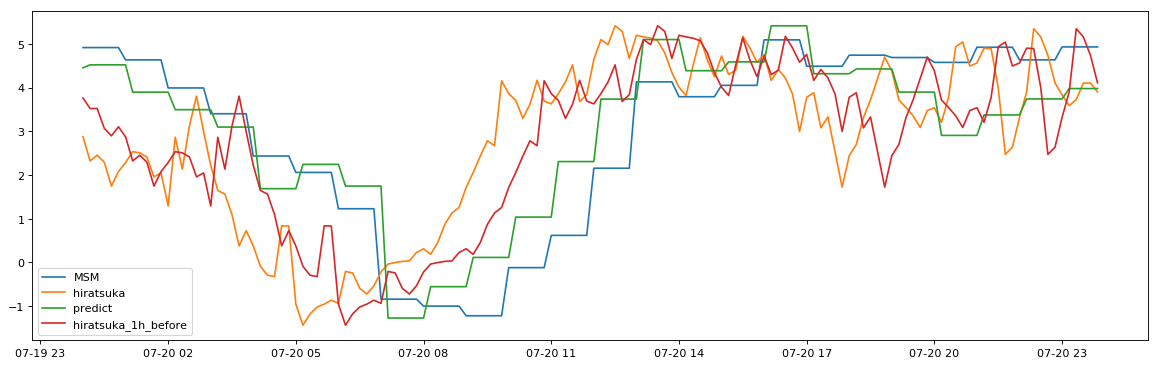

In [155]:
start = datetime(2017,7,20,0,0,0)
end = start + timedelta(days=1)
data_1 = test_data[["time", "VGRD_0"]]
data_2 = test_data[["time", "VGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_v.predict(np.array(test_x))
data_4 = test_data[["time", "VGRD"]]
data_4["time"] = data_4["time"] + timedelta(hours=1)

plot_wind([data_1, data_2, data_3, data_4], ["VGRD_0", "VGRD", "predict", "VGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)

In [156]:
# １時間前の値をそのまま使う
mean_squared_error(test_data["VGRD"], test_y["VGRD_later"])

2.7651620579137068

In [157]:
mean_squared_error(model_v.predict(np.array(test_x)), test_y["VGRD_later"])

6.7775156876230156

# version5
MSM 現在一時間後

In [164]:
# MSMのデータを10分おきに複製
date_range = pd.Series()
for year in range(2013, 2018):
    date_range = pd.concat([date_range, pd.Series(pd.date_range('{0}-07-01 09:00:00'.format(year), periods=8928 ,freq='10min'))])
data_msm_amp = pd.concat([data_msm, data_msm, data_msm, data_msm, data_msm, data_msm]).sort_values(by="time")
data_msm_amp["time"] = np.array(date_range)
data_msm_amp = data_msm_amp.reset_index(drop=True)

data = pd.merge(data_msm_amp, data_hiratsuka, on="time", how='outer')

data_msm_amp["time"] = data_msm_amp["time"] + timedelta(hours=-1)
data = pd.merge(data, data_msm_amp, on="time", how='outer', suffixes=('', '_1h_later'))

data = data.dropna()

In [165]:
# data[["time", "UGRD_0", "UGRD_0_1h_later"]]
data

,time,UGRD_0,VGRD_0,UGRD_1,VGRD_1,UGRD_2,VGRD_2,UGRD_3,VGRD_3,UGRD_4,...,UGRD_15_1h_later,VGRD_15_1h_later,UGRD_16_1h_later,VGRD_16_1h_later,UGRD_17_1h_later,VGRD_17_1h_later,UGRD_18_1h_later,VGRD_18_1h_later,UGRD_19_1h_later,VGRD_19_1h_later
0,2013-07-01 09:00:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
1,2013-07-01 09:10:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
2,2013-07-01 09:20:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
3,2013-07-01 09:30:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
4,2013-07-01 09:40:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
5,2013-07-01 09:50:00,-2.38087,3.11136,-2.09180,3.05667,-1.35743,2.40823,-0.904305,2.12698,-0.623055,...,-2.28352,3.14329,-2.01009,3.36985,-1.283520,2.96360,-0.666335,2.57298,-0.369460,2.51829
6,2013-07-01 10:00:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114
7,2013-07-01 10:10:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114
8,2013-07-01 10:20:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114
9,2013-07-01 10:30:00,-2.27571,3.21360,-1.90852,3.26829,-1.16634,2.66673,-0.689773,2.41673,-0.400710,...,-2.36462,3.10364,-1.99743,3.11145,-1.278680,2.80677,-0.731808,2.55677,-0.481808,2.54114


In [167]:
# training, test data
# 2013~2016を訓練データ、2017年をテストデータとする
start_2017 = datetime(2017,7,1,0,0,0)
train_data = data.query('time < \"{0}\" '.format(start_2017))
test_data = data.query('time >= \"{0}\" '.format(start_2017))

input_columns = []
input_columns.append("UGRD")
input_columns.append("VGRD")
for i in range(0,20):
    input_columns.append("UGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}".format(i))
for i in range(0,20):
    input_columns.append("UGRD_{0}_1h_later".format(i))
for i in range(0,20):
    input_columns.append("VGRD_{0}_1h_later".format(i))

label_columns = ["UGRD_later", "VGRD_later"]

train_x = train_data[input_columns]
train_y = train_data[label_columns]
test_x = test_data[input_columns]
test_y = test_data[label_columns]

i = 0
print("i,\tlon,\tlat,\tUGRD,\tVGRD")
for lon in lons:
    for lat in lats:
        print("{0},\t{1},\t{2},\t{3:04f},\t{4:04f}".format(i, lon, lat, mean_squared_error(test_data["UGRD_{0}".format(i)], test_data["UGRD"]), mean_squared_error(test_data["VGRD_{0}".format(i)], test_data["VGRD"])))
        i = i+1

i,	lon,	lat,	UGRD,	VGRD
0,	139.2500,	35.20,	4.095835,	4.708124
1,	139.2500,	35.25,	3.588854,	4.770420
2,	139.2500,	35.30,	4.096590,	8.495628
3,	139.2500,	35.35,	4.183734,	13.428321
4,	139.2500,	35.40,	4.014174,	13.916991
5,	139.3125,	35.20,	4.286712,	5.139098
6,	139.3125,	35.25,	3.563479,	4.529015
7,	139.3125,	35.30,	3.445168,	5.982628
8,	139.3125,	35.35,	4.090956,	10.565575
9,	139.3125,	35.40,	4.390886,	11.536093
10,	139.3750,	35.20,	4.557107,	5.575845
11,	139.3750,	35.25,	3.744974,	4.918988
12,	139.3750,	35.30,	3.283322,	5.154320
13,	139.3750,	35.35,	4.163024,	9.028239
14,	139.3750,	35.40,	4.638129,	10.804449
15,	139.4375,	35.20,	4.883292,	5.934844
16,	139.4375,	35.25,	4.067781,	5.268827
17,	139.4375,	35.30,	3.362174,	5.413088
18,	139.4375,	35.35,	4.197971,	9.212107
19,	139.4375,	35.40,	4.666142,	11.121144


In [176]:
model_v = Sequential()
model_v.add(Dense(500, input_dim = 82))
model_v.add(Activation('relu'))
model_v.add(Dense(100))
model_v.add(Activation('relu'))
model_v.add(Dense(50))
model_v.add(Activation('relu'))
model_v.add(Dense(1))
model_v.summary()
model_v.compile(optimizer = 'adam', loss = 'mse')
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_v.fit(np.array(train_x), np.array(train_y["VGRD_later"]), batch_size=10240, epochs = 1000, validation_split=0.1, callbacks=[callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 500)               41500     
_________________________________________________________________
activation_36 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 100)               50100     
_________________________________________________________________
activation_37 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 50)                5050      
_________________________________________________________________
activation_38 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 51        
Total para

31424/31424 [==============================] - 1s - loss: 2.3364 - val_loss: 3.3242
Epoch 72/1000
31424/31424 [==============================] - 1s - loss: 2.3389 - val_loss: 3.6270
Epoch 73/1000
31424/31424 [==============================] - 1s - loss: 2.3596 - val_loss: 3.4900
Epoch 74/1000
31424/31424 [==============================] - 0s - loss: 2.3718 - val_loss: 3.3796
Epoch 75/1000
31424/31424 [==============================] - 1s - loss: 2.3431 - val_loss: 3.5276
Epoch 76/1000
31424/31424 [==============================] - 0s - loss: 2.3191 - val_loss: 3.5758
Epoch 77/1000
31424/31424 [==============================] - 0s - loss: 2.3630 - val_loss: 3.3972
Epoch 78/1000
31424/31424 [==============================] - 0s - loss: 2.3634 - val_loss: 3.5555
Epoch 00077: early stopping


In [177]:
mean_squared_error(model_v.predict(np.array(test_x)), test_y["VGRD_later"])

2.2585634127488521

In [178]:
# １時間前の値をそのまま使う
mean_squared_error(test_data["VGRD"], test_y["VGRD_later"])

2.7700746785119219

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


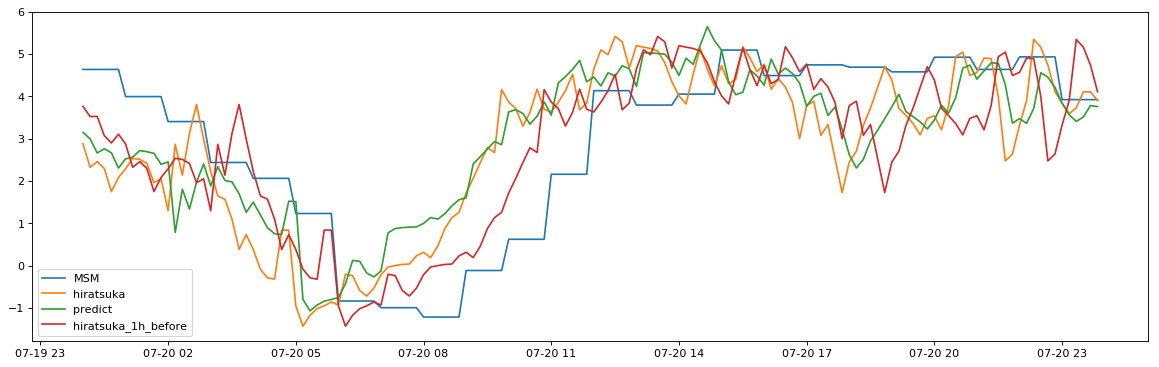

In [182]:
start = datetime(2017,7,20,0,0,0)
end = start + timedelta(days=1)
data_1 = test_data[["time", "VGRD_0"]]
data_2 = test_data[["time", "VGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_v.predict(np.array(test_x))
data_4 = test_data[["time", "VGRD"]]
data_4["time"] = data_4["time"] + timedelta(hours=1)

plot_wind([data_1, data_2, data_3, data_4], ["VGRD_0", "VGRD", "predict", "VGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)

In [187]:
model_u = Sequential()
model_u.add(Dense(500, input_dim = 82))
model_u.add(Activation('relu'))
model_u.add(Dense(100))
model_u.add(Activation('relu'))
model_u.add(Dense(50))
model_u.add(Activation('relu'))
model_u.add(Dense(1))
model_u.summary()
model_u.compile(optimizer = 'adam', loss = 'mse')
callback = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
model_u.fit(np.array(train_x), np.array(train_y["UGRD_later"]), batch_size=10240, epochs = 1000, validation_split=0.1, callbacks=[callback])

# １時間前の値をそのまま使う, 予測結果
mean_squared_error(test_data["UGRD"], test_y["UGRD_later"]), mean_squared_error(model_u.predict(np.array(test_x)), test_y["UGRD_later"])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 500)               41500     
_________________________________________________________________
activation_48 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)               50100     
_________________________________________________________________
activation_49 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 50)                5050      
_________________________________________________________________
activation_50 (Activation)   (None, 50)                0         
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 51        
Total para

(2.5086913908250037, 2.0724577241206852)

/Users/keita_kuki/.pyenv/versions/anaconda3-4.4.0/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


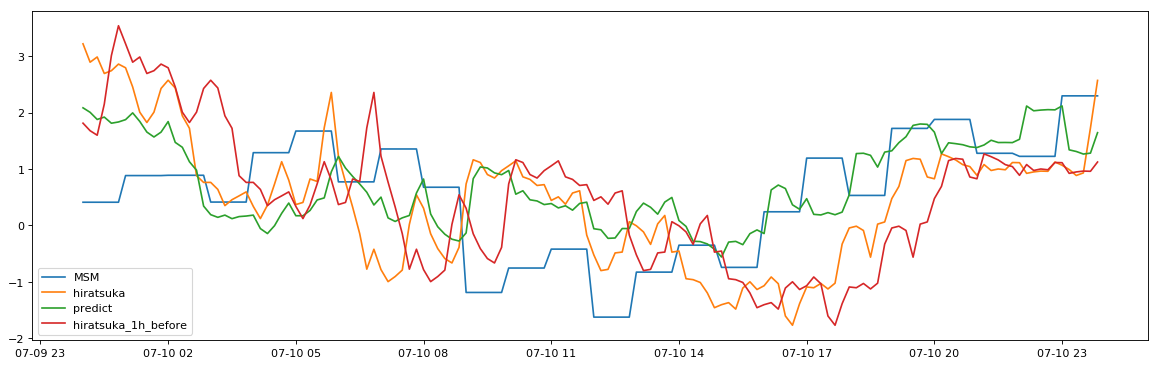

In [190]:
start = datetime(2017,7,10,0,0,0)
end = start + timedelta(days=1)
data_1 = test_data[["time", "UGRD_0"]]
data_2 = test_data[["time", "UGRD"]]
data_3 = pd.DataFrame()
data_3["time"] =  test_data["time"] + timedelta(minutes=10)
data_3["predict"] = model_u.predict(np.array(test_x))
data_4 = test_data[["time", "UGRD"]]
data_4["time"] = data_4["time"] + timedelta(hours=1)

plot_wind([data_1, data_2, data_3, data_4], ["UGRD_0", "UGRD", "predict", "UGRD"], ["MSM", "hiratsuka", "predict", "hiratsuka_1h_before"], start=start, end=end)